<font>
<div dir=ltr align=center>
<img src='Sharif_logo.png' width=250 height=250> <br>
<font color=0F5298 size=7>
Applied Data Science<br>
<font color=2565AE size=5>
Spring 2025<br>
<font color=3C99D size=5>
HW12 - Autoencoders and Generative AI <br>
<font color=696880 size=4>
Ali Mohammadzade Shabestari - 401106482 - Computer Engineering



# 1. Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
import numpy as np

# 2. Loading & Preprocessing Dataset

## 2. 1. Loading

In [38]:
df = pd.read_csv('abalone.csv')

df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


## 2. 2. Preprocessing

Encode column `Sex` (one-hot encoding).

In [40]:
# Step 1: Convert 'Sex' column to dummy variables 
sex_dummies = pd.get_dummies(df['Sex'], prefix='Sex').astype(int)

# Step 2: Drop the original 'Sex' column and add the new dummies
df = pd.concat([df.drop('Sex', axis=1), sex_dummies], axis=1)

Define bins and labels for categorization

In [41]:
bins = [0, 8, 10, 15, 30]  # Example bins
labels = ['Young', 'Adult', 'Mature', 'Old']  # Example categories

# Add a new column with categorized values
df['Age'] = pd.cut(df['Rings'], bins=bins, labels=labels, right=False)

df['Age'] = df['Age'].cat.codes  # Convert categories to numerical codes

# Add a binary category column based on 'Age'
df['Binary_Age'] = (df['Age'] > 1).astype(int)

# Display the updated dataframe
df.head()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Sex_F,Sex_I,Sex_M,Age,Binary_Age
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,0,1,3,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,0,1,0,0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1,0,0,1,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,0,1,2,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0,1,0,0,0


Split dataframe into X and y vectors.

In [42]:
X = df.drop(columns=['Rings', 'Age', 'Binary_Age'])
y = df['Age']


Standardize X values.

In [43]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## 2. 3. Split

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 2. 5. Model Builder Function

In [74]:
def create_model(optimizer='adam', learning_rate=0.001, activation='relu', 
                kernel_initializer='glorot_uniform', dropout_rate=0.0,
                l1_reg=0.0, l2_reg=0.0):
    model = Sequential()
    model.add(Dense(64, activation=activation, 
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                   input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation=activation,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(labels), activation='softmax'))
    
    if optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'adamax':
        opt = Adamax(learning_rate=learning_rate)
    elif optimizer == 'nadam':
        opt = Nadam(learning_rate=learning_rate)
    else:
        opt = Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

## 2. 6. 4-Fold Cross-Validation with Accuracy

In [87]:
def cross_validate(X_train, y_train, params, n_splits=4, epochs=50, batch_size=32):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    val_accuracies = []
    
    for train_idx, val_idx in kf.split(X_train):
        # Convert indices to numpy arrays to avoid pandas indexing issues
        train_idx = np.array(train_idx)
        val_idx = np.array(val_idx)
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        model_params = {k: v for k, v in params.items() if k != 'batch_size'}
        model = create_model(**model_params)
        history = model.fit(X_tr, y_tr, 
                           validation_data=(X_val, y_val),
                           epochs=epochs, 
                           batch_size=params.get('batch_size', batch_size),
                           verbose=0)
        val_acc = max(history.history['val_accuracy'])
        val_accuracies.append(val_acc)
    
    return np.mean(val_accuracies)


# 3. Tuning

## 3. 1. Tuning Optimizer

The optimizer determines how weight updates are calculated during training. Different optimizers (SGD, Adam, RMSprop) use varying approaches to navigate the loss landscape, with Adam typically working well for most cases by adapting learning rates per-parameter.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Optimizer: sgd, Mean Val Accuracy: 0.5822
Optimizer: adam, Mean Val Accuracy: 0.6591
Optimizer: rmsprop, Mean Val Accuracy: 0.6594
Optimizer: adamax, Mean Val Accuracy: 0.6543
Optimizer: nadam, Mean Val Accuracy: 0.6609


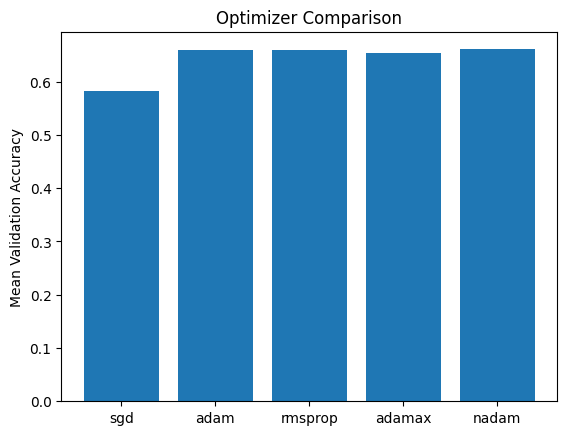

In [88]:
optimizers = ['sgd', 'adam', 'rmsprop', 'adamax', 'nadam']
opt_results = {}

for opt in optimizers:
    params = {'optimizer': opt}
    mean_val_acc = cross_validate(X_train, y_train, params)
    opt_results[opt] = mean_val_acc
    print(f"Optimizer: {opt}, Mean Val Accuracy: {mean_val_acc:.4f}")

# Plot results
plt.bar(opt_results.keys(), opt_results.values())
plt.title('Optimizer Comparison')
plt.ylabel('Mean Validation Accuracy')
plt.show()

## 3. 2. Tuning Learning Rate

This hyperparameter controls how much to adjust weights with each update. Too high causes instability, too low leads to slow convergence. Optimal rates (typically 0.001-0.1) balance training speed and stability.

Learning Rate: 0.0001, Mean Val Accuracy: 0.6504
Learning Rate: 0.001, Mean Val Accuracy: 0.6585
Learning Rate: 0.01, Mean Val Accuracy: 0.6543
Learning Rate: 0.1, Mean Val Accuracy: 0.6280
Learning Rate: 0.5, Mean Val Accuracy: 0.4121


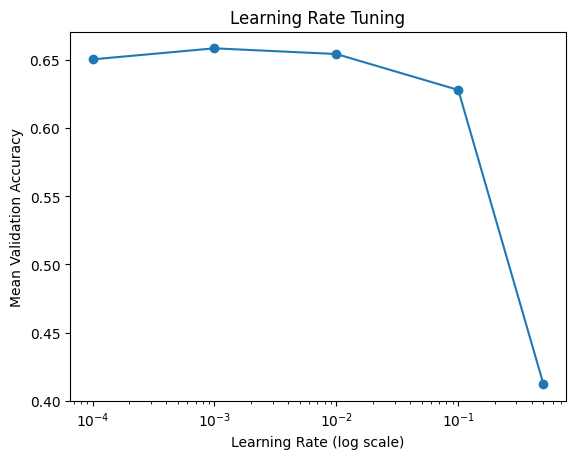

In [89]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.5]
lr_results = {}

for lr in learning_rates:
    params = {'optimizer': 'adam', 'learning_rate': lr}
    mean_val_acc = cross_validate(X_train, y_train, params)
    lr_results[lr] = mean_val_acc
    print(f"Learning Rate: {lr}, Mean Val Accuracy: {mean_val_acc:.4f}")

# Plot results
plt.plot(lr_results.keys(), lr_results.values(), marker='o')
plt.xscale('log')
plt.title('Learning Rate Tuning')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Mean Validation Accuracy')
plt.show()

## 3. 3. Tuning Learning Rate Decay

Gradually reducing the learning rate during training helps refine solutions after initial large updates. Common decay schedules include step-based or exponential reduction to enable precise convergence.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Decay Rate: 0.0, Mean Val Accuracy: 0.6600
Decay Rate: 0.0001, Mean Val Accuracy: 0.6579
Decay Rate: 0.001, Mean Val Accuracy: 0.6588
Decay Rate: 0.01, Mean Val Accuracy: 0.6576
Decay Rate: 0.1, Mean Val Accuracy: 0.6585


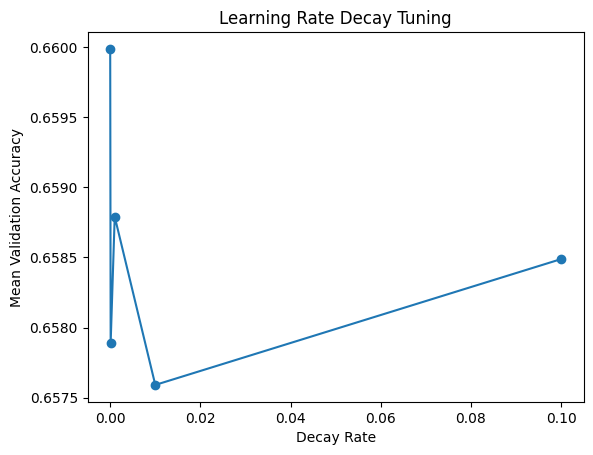

In [90]:
decay_rates = [0.0, 0.0001, 0.001, 0.01, 0.1]
decay_results = {}

def create_model_with_decay(optimizer='adam', learning_rate=0.001, decay=0.0):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(len(labels), activation='softmax'))
    
    opt = Adam(learning_rate=learning_rate, decay=decay)
    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

for decay in decay_rates:
    kf = KFold(n_splits=4, shuffle=True, random_state=42)
    val_accuracies = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        
        model = create_model_with_decay(decay=decay)
        history = model.fit(X_tr, y_tr, 
                           validation_data=(X_val, y_val),
                           epochs=50, 
                           batch_size=32,
                           verbose=0)
        val_acc = max(history.history['val_accuracy'])
        val_accuracies.append(val_acc)
    
    mean_val_acc = np.mean(val_accuracies)
    decay_results[decay] = mean_val_acc
    print(f"Decay Rate: {decay}, Mean Val Accuracy: {mean_val_acc:.4f}")

# Plot results
plt.plot(decay_results.keys(), decay_results.values(), marker='o')
plt.title('Learning Rate Decay Tuning')
plt.xlabel('Decay Rate')
plt.ylabel('Mean Validation Accuracy')
plt.show()

## 3. 4.  Tuning Batch Size

The number of samples processed before updating weights affects both training stability and speed. Smaller batches (32-128) often generalize better but require more updates, while larger batches train faster but may converge to sharper minima.

Batch Size: 16, Mean Val Accuracy: 0.6552
Batch Size: 32, Mean Val Accuracy: 0.6588
Batch Size: 64, Mean Val Accuracy: 0.6588
Batch Size: 128, Mean Val Accuracy: 0.6615
Batch Size: 256, Mean Val Accuracy: 0.6531


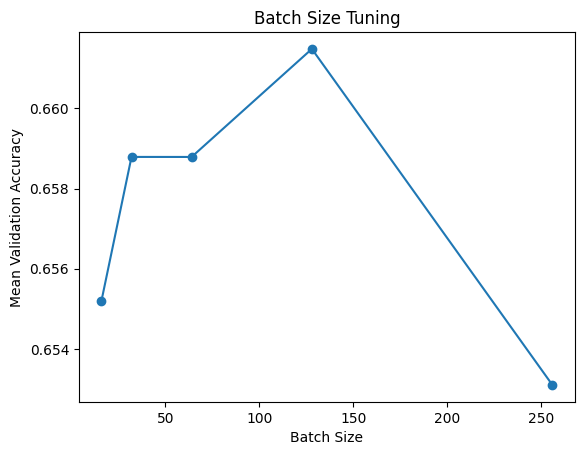

In [91]:
batch_sizes = [16, 32, 64, 128, 256]
batch_results = {}

for batch_size in batch_sizes:
    params = {'optimizer': 'adam', 'batch_size': batch_size}
    mean_val_acc = cross_validate(X_train, y_train, params)
    batch_results[batch_size] = mean_val_acc
    print(f"Batch Size: {batch_size}, Mean Val Accuracy: {mean_val_acc:.4f}")

# Plot results
plt.plot(batch_results.keys(), batch_results.values(), marker='o')
plt.title('Batch Size Tuning')
plt.xlabel('Batch Size')
plt.ylabel('Mean Validation Accuracy')
plt.show()

## 3. 5. Tuning Activation Functions

These introduce non-linearity (ReLU, sigmoid, tanh) enabling complex pattern learning. ReLU is commonly preferred for hidden layers due to its computational efficiency and mitigation of vanishing gradients.

Activation: relu, Mean Val Accuracy: 0.6570
Activation: sigmoid, Mean Val Accuracy: 0.6465
Activation: tanh, Mean Val Accuracy: 0.6612
Activation: elu, Mean Val Accuracy: 0.6606
Activation: leaky_relu, Mean Val Accuracy: 0.6627


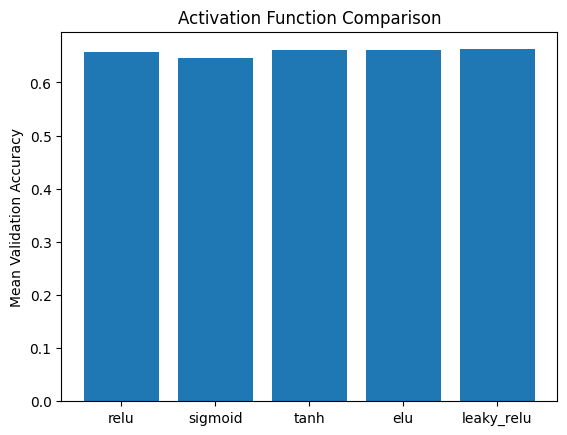

In [92]:
activations = ['relu', 'sigmoid', 'tanh', 'elu', 'leaky_relu']
activation_results = {}

for activation in activations:
    params = {'optimizer': 'adam', 'activation': activation}
    mean_val_acc = cross_validate(X_train, y_train, params)
    activation_results[activation] = mean_val_acc
    print(f"Activation: {activation}, Mean Val Accuracy: {mean_val_acc:.4f}")

# Plot results
plt.bar(activation_results.keys(), activation_results.values())
plt.title('Activation Function Comparison')
plt.ylabel('Mean Validation Accuracy')
plt.show()

## 3. 6. Tuning Weight Initialization

 Proper initialization (He, Xavier) sets weights to optimal starting ranges to prevent early vanishing/exploding gradients. The method depends on the activation function used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Initializer: glorot_uniform, Mean Val Accuracy: 0.6573
Initializer: he_normal, Mean Val Accuracy: 0.6528
Initializer: lecun_uniform, Mean Val Accuracy: 0.6588
Initializer: random_normal, Mean Val Accuracy: 0.6615
Initializer: zeros, Mean Val Accuracy: 0.4121


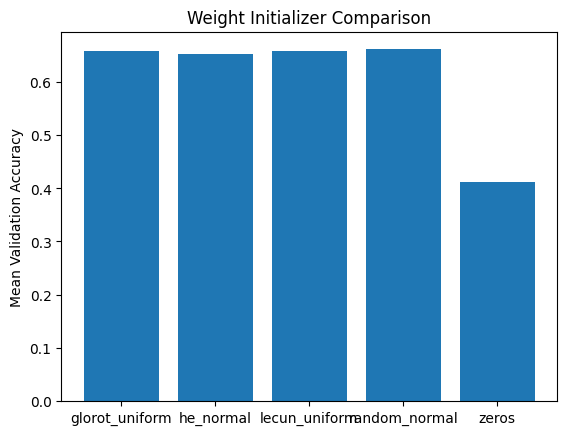

In [94]:
initializers = ['glorot_uniform', 'he_normal', 'lecun_uniform', 'random_normal', 'zeros']
init_results = {}

for init in initializers:
    params = {'optimizer': 'adam', 'kernel_initializer': init}
    mean_val_acc = cross_validate(X_train, y_train, params)
    init_results[init] = mean_val_acc
    print(f"Initializer: {init}, Mean Val Accuracy: {mean_val_acc:.4f}")

# Plot results
plt.bar(init_results.keys(), init_results.values())
plt.title('Weight Initializer Comparison')
plt.ylabel('Mean Validation Accuracy')
plt.show()

## 3. 7. Network Architecture

Layer depth and width determine model capacity. Deeper networks can learn more complex features but require careful regularization to prevent overfitting.

Architecture: Single 64, Mean Val Accuracy: 0.6564
Architecture: 128-64, Mean Val Accuracy: 0.6576
Architecture: 64-32-16, Mean Val Accuracy: 0.6615
Architecture: 256-128-64-32, Mean Val Accuracy: 0.6576
Architecture: 512-256-128-64-32, Mean Val Accuracy: 0.6585


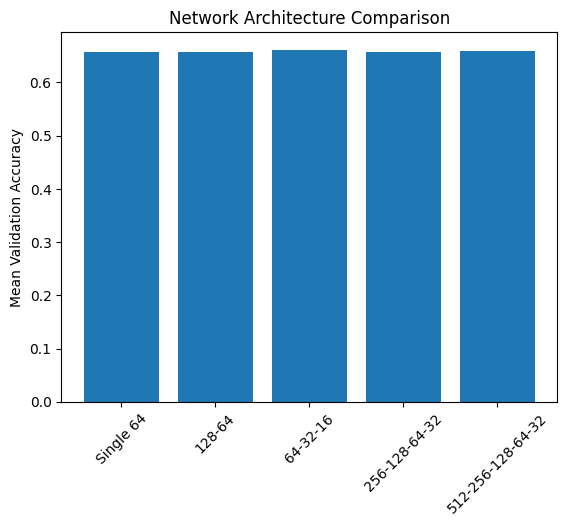

In [95]:
architectures = [
    {'layers': [64], 'name': 'Single 64'},
    {'layers': [128, 64], 'name': '128-64'},
    {'layers': [64, 32, 16], 'name': '64-32-16'},
    {'layers': [256, 128, 64, 32], 'name': '256-128-64-32'},
    {'layers': [512, 256, 128, 64, 32], 'name': '512-256-128-64-32'}
]

arch_results = {}

def create_architecture_model(layers, optimizer='adam'):
    model = Sequential()
    model.add(Dense(layers[0], activation='relu', input_shape=(X_train.shape[1],)))
    
    for units in layers[1:]:
        model.add(Dense(units, activation='relu'))
    
    model.add(Dense(len(labels), activation='softmax'))
    
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

for arch in architectures:
    kf = KFold(n_splits=4, shuffle=True, random_state=42)
    val_accuracies = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        model = create_architecture_model(arch['layers'])
        history = model.fit(X_tr, y_tr, 
                           validation_data=(X_val, y_val),
                           epochs=50, 
                           batch_size=32,
                           verbose=0)
        val_acc = max(history.history['val_accuracy'])
        val_accuracies.append(val_acc)
    
    mean_val_acc = np.mean(val_accuracies)
    arch_results[arch['name']] = mean_val_acc
    print(f"Architecture: {arch['name']}, Mean Val Accuracy: {mean_val_acc:.4f}")

# Plot results
plt.bar(arch_results.keys(), arch_results.values())
plt.title('Network Architecture Comparison')
plt.ylabel('Mean Validation Accuracy')
plt.xticks(rotation=45)
plt.show()

## 3. 8. Tuning L1 and L2 Regularization in Weights 

L1/L2 regularization adds penalty terms to the loss function to prevent overfitting by discouraging large weight values, with L2 generally being more commonly used.

Regularization: No reg, Mean Val Accuracy: 0.6597
Regularization: L1 0.001, Mean Val Accuracy: 0.6603
Regularization: L2 0.001, Mean Val Accuracy: 0.6585
Regularization: L1L2 0.001, Mean Val Accuracy: 0.6600
Regularization: L1L2 0.01, Mean Val Accuracy: 0.6327


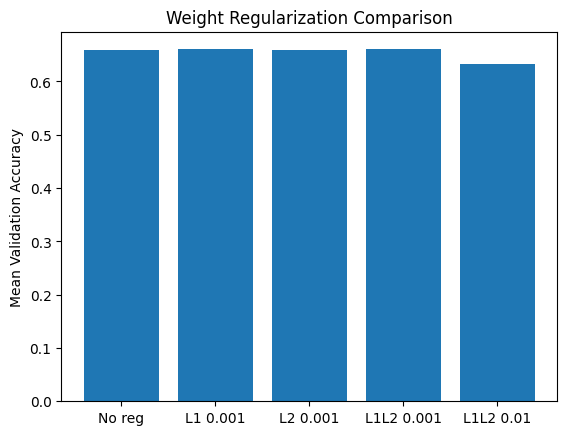

In [96]:
reg_combinations = [
    {'l1': 0.0, 'l2': 0.0, 'name': 'No reg'},
    {'l1': 0.001, 'l2': 0.0, 'name': 'L1 0.001'},
    {'l1': 0.0, 'l2': 0.001, 'name': 'L2 0.001'},
    {'l1': 0.001, 'l2': 0.001, 'name': 'L1L2 0.001'},
    {'l1': 0.01, 'l2': 0.01, 'name': 'L1L2 0.01'}
]

reg_results = {}

for reg in reg_combinations:
    params = {'optimizer': 'adam', 'l1_reg': reg['l1'], 'l2_reg': reg['l2']}
    mean_val_acc = cross_validate(X_train, y_train, params)
    reg_results[reg['name']] = mean_val_acc
    print(f"Regularization: {reg['name']}, Mean Val Accuracy: {mean_val_acc:.4f}")

# Plot results
plt.bar(reg_results.keys(), reg_results.values())
plt.title('Weight Regularization Comparison')
plt.ylabel('Mean Validation Accuracy')
plt.show()

## 3. 9. Tuning Activity Regularization

This applies penalties to layer outputs rather than weights, encouraging the network to develop more robust internal representations.

Activity L2 Reg: 0.0, Mean Val Accuracy: 0.6579
Activity L2 Reg: 0.0001, Mean Val Accuracy: 0.6591
Activity L2 Reg: 0.001, Mean Val Accuracy: 0.6564
Activity L2 Reg: 0.01, Mean Val Accuracy: 0.6519
Activity L2 Reg: 0.1, Mean Val Accuracy: 0.5253


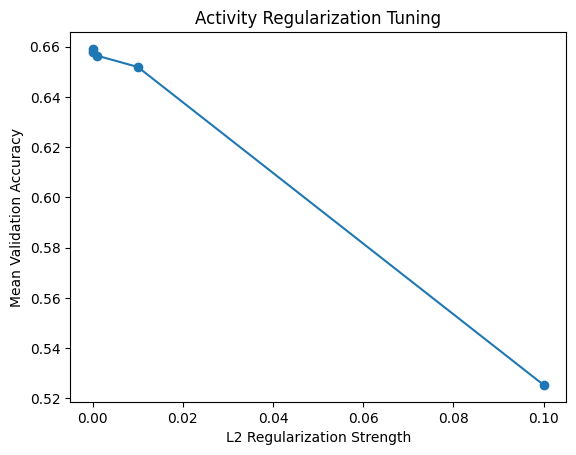

In [97]:
activity_regs = [0.0, 0.0001, 0.001, 0.01, 0.1]
activity_results = {}

def create_model_with_activity_reg(activity_l1=0.0, activity_l2=0.0):
    model = Sequential()
    model.add(Dense(64, activation='relu', 
                   activity_regularizer=l1_l2(l1=activity_l1, l2=activity_l2),
                   input_shape=(X_train.shape[1],)))
    model.add(Dense(32, activation='relu',
                   activity_regularizer=l1_l2(l1=activity_l1, l2=activity_l2)))
    model.add(Dense(len(labels), activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

for reg in activity_regs:
    kf = KFold(n_splits=4, shuffle=True, random_state=42)
    val_accuracies = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        model = create_model_with_activity_reg(activity_l2=reg)
        history = model.fit(X_tr, y_tr, 
                           validation_data=(X_val, y_val),
                           epochs=50, 
                           batch_size=32,
                           verbose=0)
        val_acc = max(history.history['val_accuracy'])
        val_accuracies.append(val_acc)
    
    mean_val_acc = np.mean(val_accuracies)
    activity_results[reg] = mean_val_acc
    print(f"Activity L2 Reg: {reg}, Mean Val Accuracy: {mean_val_acc:.4f}")

# Plot results
plt.plot(activity_results.keys(), activity_results.values(), marker='o')
plt.title('Activity Regularization Tuning')
plt.xlabel('L2 Regularization Strength')
plt.ylabel('Mean Validation Accuracy')
plt.show()

## 3. 10. Tuning Dropout Rate

This technique randomly deactivates neurons during training (typically with rate 0.2-0.5) to prevent co-adaptation and improve generalization by creating an ensemble effect.

Dropout Rate: 0.0, Mean Val Accuracy: 0.6573
Dropout Rate: 0.1, Mean Val Accuracy: 0.6612
Dropout Rate: 0.2, Mean Val Accuracy: 0.6603
Dropout Rate: 0.3, Mean Val Accuracy: 0.6612
Dropout Rate: 0.5, Mean Val Accuracy: 0.6552


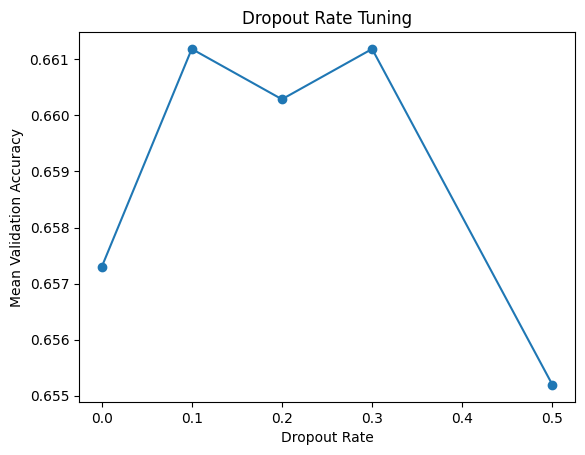

In [98]:
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.5]
dropout_results = {}

for rate in dropout_rates:
    params = {'optimizer': 'adam', 'dropout_rate': rate}
    mean_val_acc = cross_validate(X_train, y_train, params)
    dropout_results[rate] = mean_val_acc
    print(f"Dropout Rate: {rate}, Mean Val Accuracy: {mean_val_acc:.4f}")

# Plot results
plt.plot(dropout_results.keys(), dropout_results.values(), marker='o')
plt.title('Dropout Rate Tuning')
plt.xlabel('Dropout Rate')
plt.ylabel('Mean Validation Accuracy')
plt.show()

❓ Why it gets more difficult to train deep neural networks when the number of layers increase


✅ 
Gradient Issues: Gradients vanish (→0) or explode (→∞) during backpropagation through many layers, hindering early layer learning.

Computational Burden: More layers increase parameters, slowing training and raising overfitting risks.

Optimization Difficulty: Complex loss landscapes with many local minima/saddle points challenge convergence.

Information Loss: Input signals weaken through excessive transformations.

Initialization Sensitivity: Weight initialization critically impacts training success.

Solutions: Skip connections (ResNet), batch normalization, advanced optimizers, and careful initialization enable deeper network training.